 ### MSc. Exploration and Applied Geophysics, Università di Pisa
##### Seismic Imaging Course 2024
##### Full Waveform Inversion & Reverse Time Migration


- **Professor:** Nicola Bienati
- **Contact info:** Felipe Rincón - felipe.rincon@phd.unipi.it


In [42]:
#import libraries
import numpy as np

from devito import Operator,Eq,solve,Grid,SparseFunction
from devito import TimeFunction,Function, norm
from devito import gaussian_smooth
from devito import mmax

from devito.logger import info

from examples.seismic import Model
from examples.seismic import plot_velocity,plot_shotrecord
from examples.seismic import Receiver
from examples.seismic import PointSource
from examples.seismic import plot_image,AcquisitionGeometry
from examples.seismic import TimeAxis

from examples.seismic.self_adjoint import (setup_w_over_q)
from examples.seismic.acoustic import AcousticWaveSolver

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.ticker as plticker

from devito import configuration
from examples.seismic import demo_model, plot_velocity, plot_perturbation

import scipy

configuration['log-level'] = 'WARNING'

# Select the location of the source and receiver array
#1 TOP
#2 LEFT
#3 BOTTOM
#4 RIGHT
case_rcv=1234
case_src=1234



In [63]:
#user_functions

def generate_source_locations(case,nshots):
    # Prepare the varying source locations sources
    source_locations1 = np.empty((nshots, 2), dtype=np.float32)
    source_locations1[:, 0] = np.linspace(0., 1000, num=nshots)
    source_locations1[:, 1] = 20.

    source_locations2 = np.empty((nshots, 2), dtype=np.float32)
    source_locations2[:, 0] = 20
    source_locations2[:, 1] = np.linspace(0., 1000, num=nshots)

    source_locations3 = np.empty((nshots, 2), dtype=np.float32)
    source_locations3[:, 0] = np.linspace(0., 1000, num=nshots)
    source_locations3[:, 1] = 980.

    source_locations4 = np.empty((nshots, 2), dtype=np.float32)
    source_locations4[:, 0] = 980
    source_locations4[:, 1] = np.linspace(0., 1000, num=nshots)

    # Choose the appropriate source locations based on the case
    if case == 1:
        source_locations = source_locations1
    elif case == 2:
        source_locations = source_locations2
    elif case == 3:
        source_locations = source_locations3
    elif case == 4:
        source_locations = source_locations4
    elif case == 12:
        source_locations = np.concatenate((source_locations1, source_locations2))
    elif case == 13:
        source_locations = np.concatenate((source_locations1, source_locations3))
    elif case == 14:
        source_locations = np.concatenate((source_locations1, source_locations4))
    elif case == 23:
        source_locations = np.concatenate((source_locations2, source_locations3))
    elif case == 24:
        source_locations = np.concatenate((source_locations2, source_locations4))
    elif case == 34:
        source_locations = np.concatenate((source_locations3, source_locations4))
    elif case == 123:
        source_locations = np.concatenate((source_locations1, source_locations2, source_locations3))
    elif case == 124:
        source_locations = np.concatenate((source_locations1, source_locations2, source_locations4))
    elif case == 134:
        source_locations = np.concatenate((source_locations1, source_locations3, source_locations4))
    elif case == 234:
        source_locations = np.concatenate((source_locations2, source_locations3, source_locations4))
    elif case == 1234:
        source_locations = np.concatenate((source_locations1, source_locations2, source_locations3, source_locations4))
    else:
        raise ValueError("Invalid source case. Please choose a value between 1 and 1234. e.g. 1, 13, 123, 24, 234")
    return source_locations

def generate_receiver_coordinates(case, nreceivers, domain_size):
    # Initialize receivers for synthetic and imaging data
    rec_coordinates1 = np.empty((nreceivers, 2))
    rec_coordinates1[:, 1] = 0
    rec_coordinates1[:, 0] = np.linspace(0, domain_size[0], num=nreceivers)

    rec_coordinates2 = np.empty((nreceivers, 2))
    rec_coordinates2[:, 1] = np.linspace(0, domain_size[0], num=nreceivers)
    rec_coordinates2[:, 0] = 0

    rec_coordinates3 = np.empty((nreceivers, 2))
    rec_coordinates3[:, 1] = domain_size[0]
    rec_coordinates3[:, 0] = np.linspace(0, domain_size[0], num=nreceivers)

    rec_coordinates4 = np.empty((nreceivers, 2))
    rec_coordinates4[:, 1] = np.linspace(0, domain_size[1], num=nreceivers)
    rec_coordinates4[:, 0] = domain_size[0]

    # Choose the appropriate receiver coordinates based on the case
    if case == 1:
        rec_coordinates = rec_coordinates1
    elif case == 2:
        rec_coordinates = rec_coordinates2
    elif case == 3:
        rec_coordinates = rec_coordinates3
    elif case == 4:
        rec_coordinates = rec_coordinates4
    elif case == 12:
        rec_coordinates = np.concatenate((rec_coordinates1, rec_coordinates2))
    elif case == 13:
        rec_coordinates = np.concatenate((rec_coordinates1, rec_coordinates3))
    elif case == 14:
        rec_coordinates = np.concatenate((rec_coordinates1, rec_coordinates4))
    elif case == 23:
        rec_coordinates = np.concatenate((rec_coordinates2, rec_coordinates3))
    elif case == 24:
        rec_coordinates = np.concatenate((rec_coordinates2, rec_coordinates4))
    elif case == 34:
        rec_coordinates = np.concatenate((rec_coordinates3, rec_coordinates4))
    elif case == 123:
        rec_coordinates = np.concatenate((rec_coordinates1, rec_coordinates2, rec_coordinates3))
    elif case == 124:
        rec_coordinates = np.concatenate((rec_coordinates1, rec_coordinates2, rec_coordinates4))
    elif case == 134:
        rec_coordinates = np.concatenate((rec_coordinates1, rec_coordinates3, rec_coordinates4))
    elif case == 234:
        rec_coordinates = np.concatenate((rec_coordinates2, rec_coordinates3, rec_coordinates4))
    elif case == 1234:
        rec_coordinates = np.concatenate((rec_coordinates1, rec_coordinates2, rec_coordinates3, rec_coordinates4))
    else:
        raise ValueError("Invalid receiver case. Please choose a value between 1 and 1234. e.g. 1, 13, 123, 24, 234")
    return rec_coordinates

def plot_shotrecord2(rec, model, t0, tn, colorbar=True, name=None):
    """
    Plot a shot record (receiver values over time).

    Parameters
    ----------
    rec :
        Receiver data with shape (time, points).
    model : Model
        object that holds the velocity model.
    t0 : int
        Start of time dimension to plot.
    tn : int
        End of time dimension to plot.
    """
    scale = np.max(rec) / 10.
    extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
              1e-3*tn, t0]
        
    plot = plt.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
    plt.xlabel('Distance (km)')
    plt.ylabel('Time (s)')
    plt.title(name)
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.show()

def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

def fwi_gradient(vp_in,true_model, geometry, nshots,source_locations,solver, mult):    
    grad = Function(name="grad", grid=true_model.grid)
    residual = Receiver(name='residual', grid=true_model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=true_model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=true_model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots*mult):
        geometry.src_positions[0, :] = source_locations[i, :]
        _, _, _ = solver.forward(vp=true_model.vp, rec=d_obs) 
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)    
    return objective, grad

def plot_velocity_clim(model, source=None, receiver=None, colorbar=True, cmap=None, vmin=None, vmax=None, name=None):
    domain_size = 1.e-3 * np.array(model.domain_size)
    extent = [model.origin[0], model.origin[0] + domain_size[0],
              model.origin[1] + domain_size[1], model.origin[1]]

    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    if getattr(model, 'vp', None) is not None:
        field = model.vp.data[slices]
    else:
        field = model.lam.data[slices]

    # Set vmin and vmax based on arguments, or default to data range
    if vmin is None:
        vmin = np.min(field)
    if vmax is None:
        vmax = np.max(field)

    plot = plt.imshow(np.transpose(field), animated=True, cmap=cmap,
                      vmin=vmin, vmax=vmax, extent=extent)
    plt.xlabel('Distance (km)')
    plt.ylabel('Depth (km)')
    plt.title(name)

    if receiver is not None:
        plt.scatter(1e-3*receiver[:, 0], 1e-3*receiver[:, 1], s=25, c='green', marker='D')
    if source is not None:
        plt.scatter(1e-3*source[:, 0], 1e-3*source[:, 1], s=25, c='red', marker='o')

    plt.xlim(model.origin[0], model.origin[0] + domain_size[0])
    plt.ylim(model.origin[1] + domain_size[1], model.origin[1])

    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(plot, cax=cax)
        cbar.set_label('Velocity (km/s)')
    plt.show()

def ImagingOperator(model, image, geometry):
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
                     save=geometry.nt)
    
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T
    stencil = Eq(v.backward, solve(eqn, v.backward))
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update],
                    subs=model.spacing_map)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_shotrecord_array(rec, model, t0, tn, case_rcv, colorbar=True, name=None):
    """
    Plot a shot record (receiver values over time).

    Parameters
    ----------
    rec :
        Receiver data with shape (time, points).
    model : Model
        object that holds the velocity model.
    t0 : int
        Start of time dimension to plot.
    tn : int
        End of time dimension to plot.
    case_rcv : int
        Indicates the location of the source and receiver array:
        1 - Top
        2 - Left
        3 - Bottom
        4 - Right
    colorbar : bool, optional
        Whether to show the colorbar. Default is True.
    name : str, optional
        Title for the entire figure. Default is 'True data'.
    """
    scale = np.max(rec) / 10.
    extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
              1e-3*tn, t0]

    num_plots = len(str(case_rcv))
    rows = 1
    cols = num_plots

    fig, axes = plt.subplots(rows, cols, figsize=(5*num_plots, 5))
    if num_plots == 1:
        axes = [axes] 

    fig.suptitle(name, fontsize=16, fontweight='bold', y=0.98, ha='center')  # Add general title

    for i in range(num_plots):
        rec_slice = slice_shotrecord(rec, case_rcv % 10)
        if case_rcv % 10 == 1:
            axes[i].imshow(rec_slice, vmin=-scale, vmax=scale, cmap='gray', extent=extent)
            axes[i].set_title('Top receivers')
        elif case_rcv % 10 == 2:
            axes[i].imshow(rec_slice, vmin=-scale, vmax=scale, cmap='gray', extent=extent)
            axes[i].set_title('Left receivers')
        elif case_rcv % 10 == 3:
            axes[i].imshow(rec_slice, vmin=-scale, vmax=scale, cmap='gray', extent=extent)
            axes[i].set_title('Bottom receivers')
        elif case_rcv % 10 == 4:
            axes[i].imshow(rec_slice, vmin=-scale, vmax=scale, cmap='gray', extent=extent)
            axes[i].set_title('Right receivers')
        axes[i].set_xlabel('X position (km)')
        if i == 0:  # Only set y-label for the first subplot
            axes[i].set_ylabel('Time (s)')
        case_rcv = case_rcv // 10

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca() if num_plots == 1 else axes[-1]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(ax.images[0], cax=cax)
    plt.show()


def slice_shotrecord(rec, case):
    """
    Slice the shot record data based on the case.

    Parameters
    ----------
    rec : numpy.ndarray
        Receiver data with shape (time, points).
    case : int
        Indicates the location of the source and receiver array:
        1 - Top
        2 - Left
        3 - Bottom
        4 - Right

    Returns
    -------
    numpy.ndarray
        Sliced shot record data.
    """
    num_columns = rec.shape[1]
    if case == 1:
        return rec[:, :num_columns // 4]
    elif case == 2:
        return rec[:, num_columns // 4 : num_columns // 2]
    elif case == 3:
        return rec[:, num_columns // 2 : 3 * num_columns // 4]
    elif case == 4:
        return rec[:, 3 * num_columns // 4:]


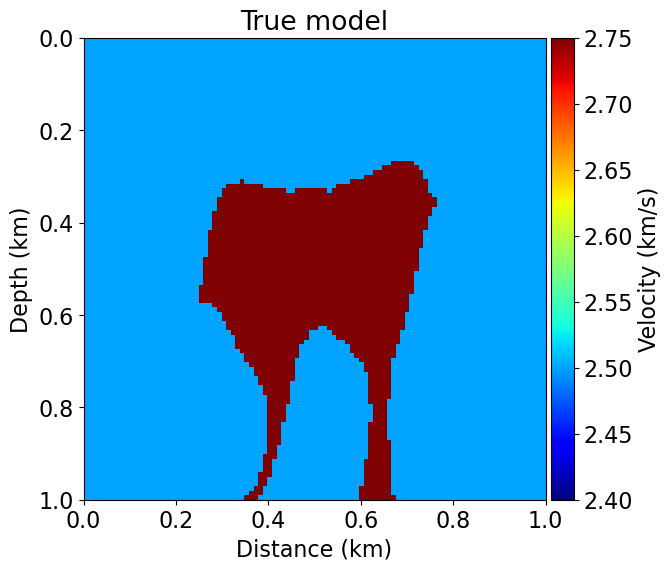

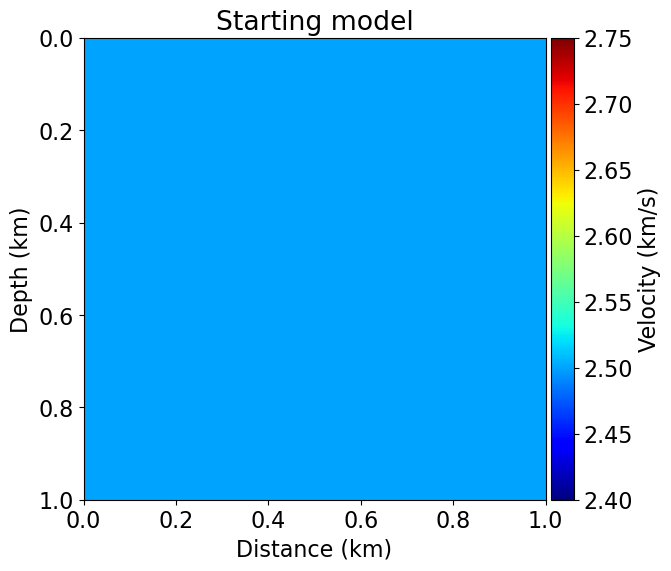

In [44]:
import numpy as np
from examples.seismic import demo_model, plot_velocity, plot_perturbation
from devito import configuration


configuration['log-level'] = 'WARNING'
nshots = 10  # Number of shots
nreceivers = 101  # Number of receivers
fwi_iterations = 14  # Number of iterations

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.) #in meters
origin = (0., 0.) 

vp_bck=2.5 #background velocity in km/s
nbl=40 # Number absorbing points for PML

#to add layers to the model
#v[0:30,:]= vp_bck -0.5 # add the first layer
#v[101-30:101,:]= vp_bck +0.55 # add the third layer

v=np.load('/path/to/../model1.npy')
v=np.transpose(v)


true_model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")

plot_velocity_clim(true_model, vmin=2.4, vmax=2.75,name="True model", cmap="jet")


#create an starting model
v2=np.ones(shape)*vp_bck
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(start_model, vmin=2.4, vmax=2.75,name="Starting model", cmap="jet")


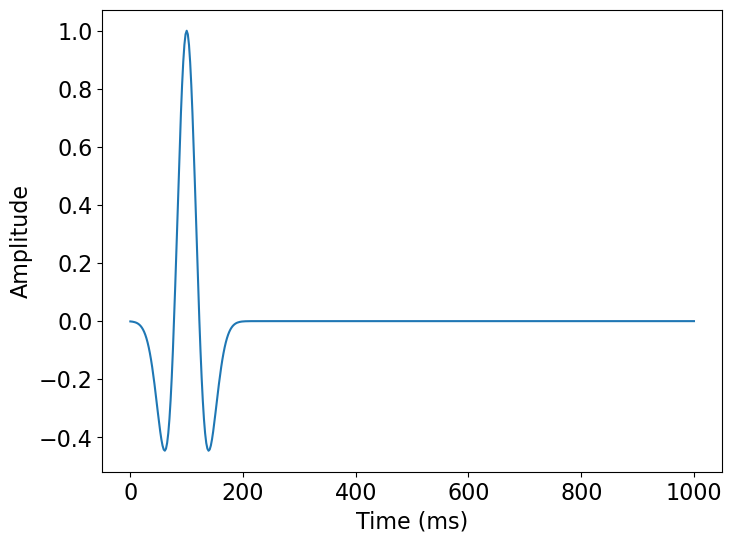

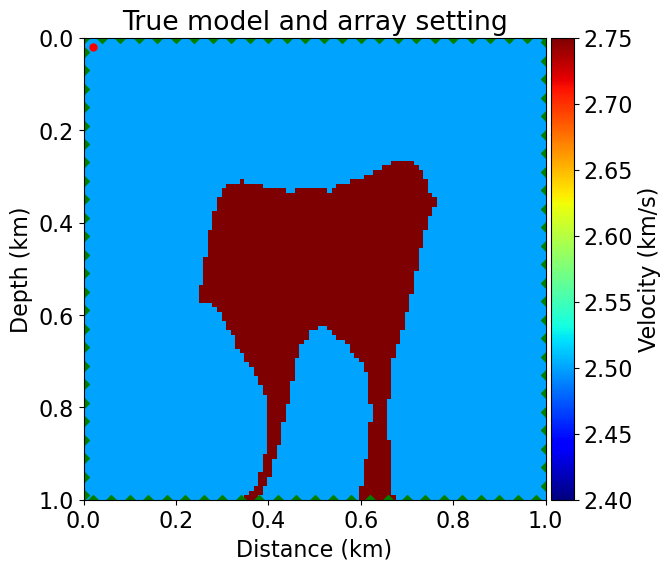

In [115]:
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

t0 = 0
time = 1000 
dt = 0.01

src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = 20
src_coordinates[0, 0] = 20

rec_coordinates = generate_receiver_coordinates(case=case_rcv, nreceivers=nreceivers, domain_size=true_model.domain_size)

geometry = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt, src_type='Ricker')
geometry.src.show()

plot_velocity_clim(true_model, vmin=2.4, vmax=2.75,name="True model and array setting", cmap="jet", source=geometry.src_positions,receiver=geometry.rec_positions[::4, :])


In [112]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver
solver = AcousticWaveSolver(true_model, geometry, space_order=4)
true_data, _, _ = solver.forward(vp=true_model.vp)

# Compute initial data with forward operator 
initial_data, _, _ = solver.forward(vp=start_model.vp)

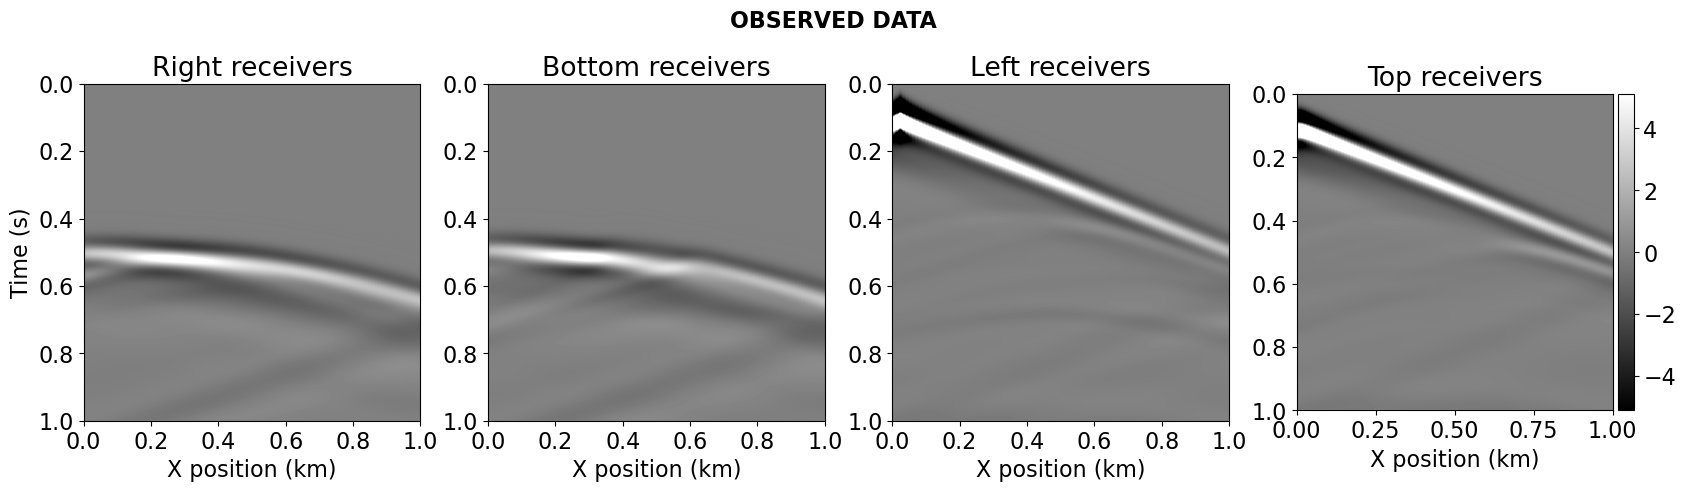

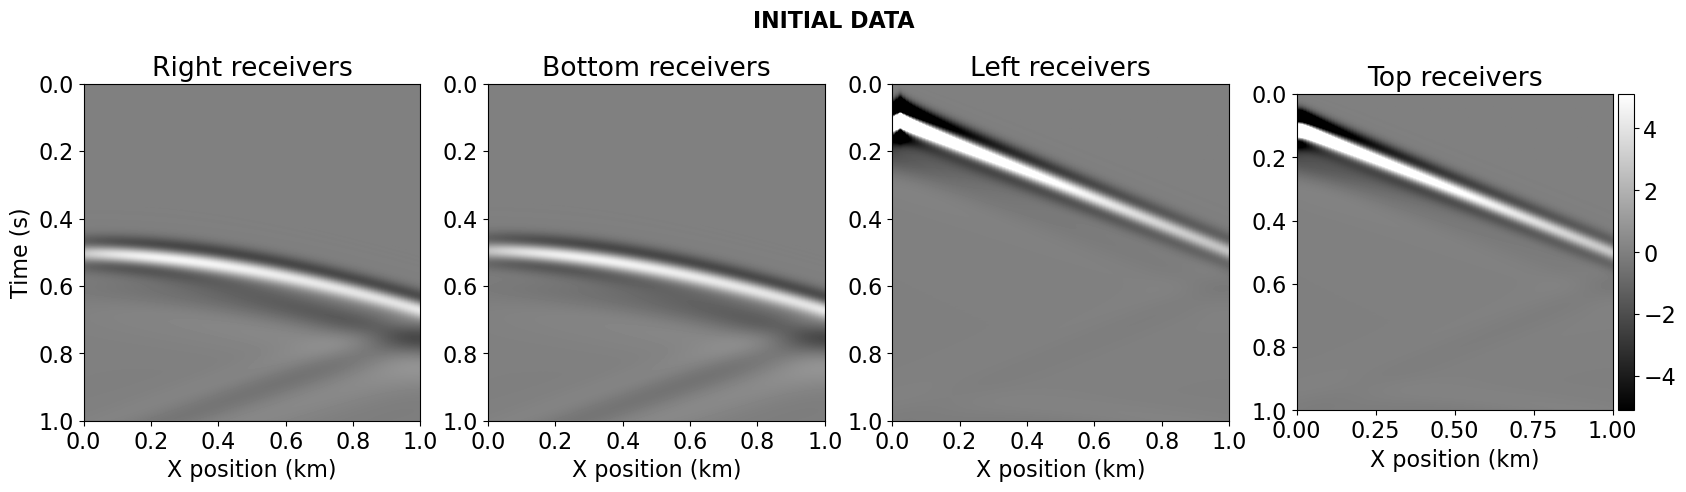

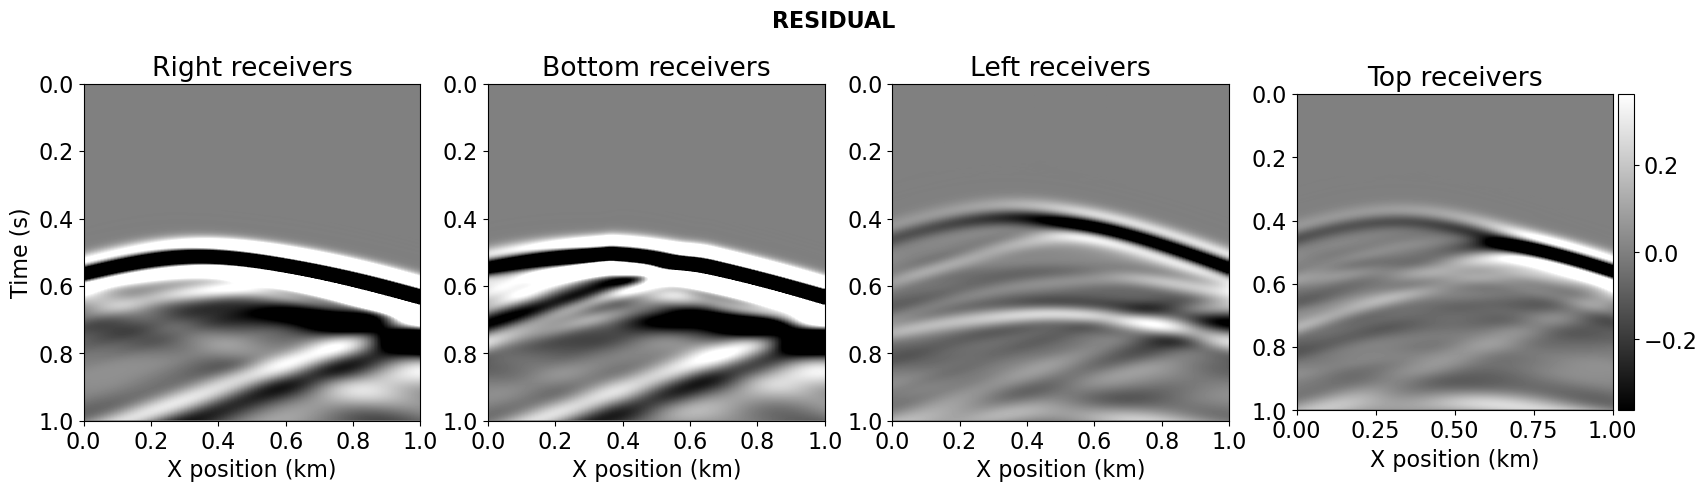

In [114]:
plot_shotrecord_array(true_data.data, true_model, t0, time, case_rcv, colorbar=True,name='OBSERVED DATA')
plot_shotrecord_array(initial_data.data, true_model, t0, time, case_rcv, colorbar=True,name='INITIAL DATA')
plot_shotrecord_array(initial_data.data - true_data.data, true_model, t0, time, case_rcv, colorbar=True,name='RESIDUAL')


In [48]:
model=true_model

scale = np.max(true_data.data) / 10.
extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
            1e-3*time, t0]

num_plots = len(str(case_rcv))
rows = 1
cols = num_plots

rec=true_data.data

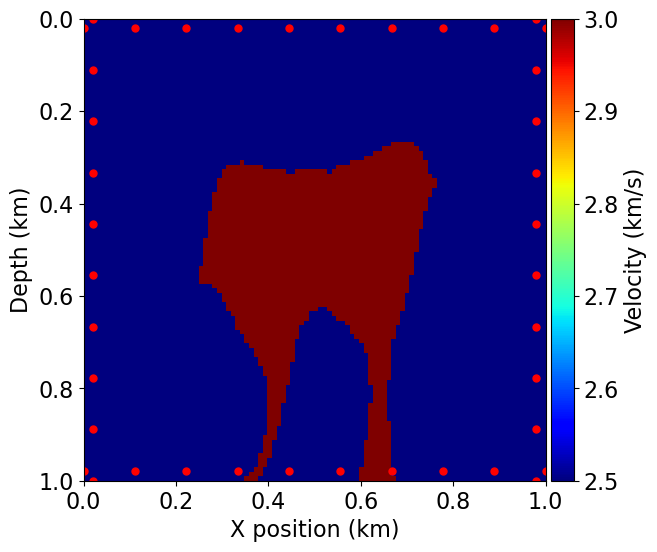

In [49]:
mult = len(str(case_src))
source_locations = generate_source_locations(case=case_src,nshots=nshots)

plot_velocity(true_model, source=source_locations)

#compute the gradient
ff, update = fwi_gradient(vp_in=start_model.vp,true_model=true_model, geometry=geometry, nshots=nshots,source_locations=source_locations,solver=solver, mult=mult)

# Plot the FWI gradient
a=-update.data[nbl:shape[0]+nbl,nbl:shape[1]+nbl]


# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
b=(true_model.vp.data-start_model.vp.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]

# Show what the update does to the model
alpha = .5 / mmax(update)
c=(start_model.vp.data + alpha*update.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]


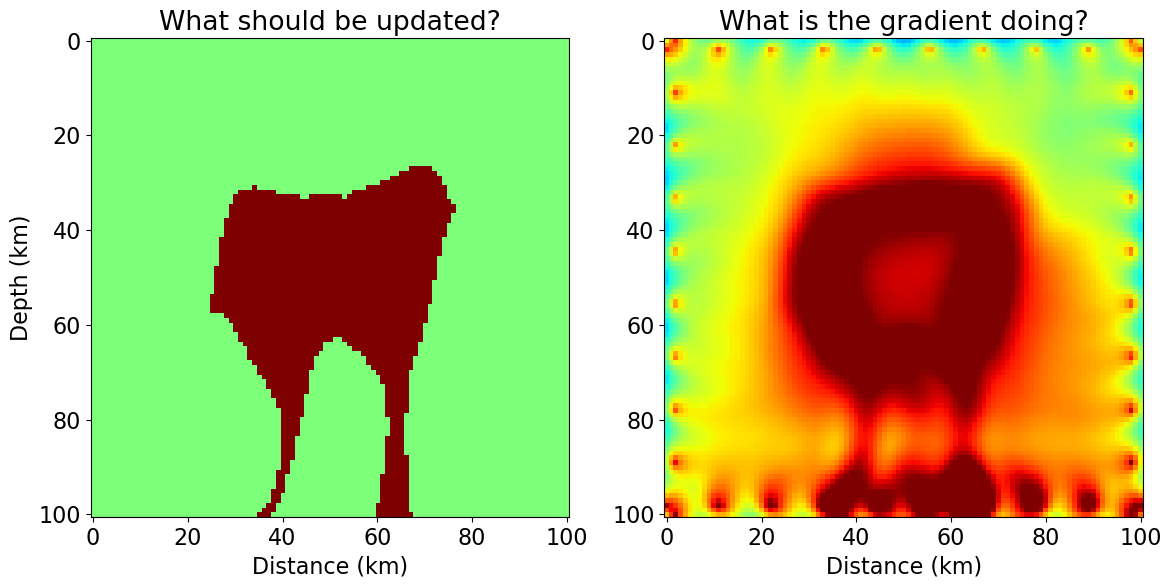

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im1 = axes[0].imshow(np.transpose(b), vmin=-0.1, vmax=0.1, cmap="jet")
axes[0].set_title('What should be updated?')
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Depth (km)')
#plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(np.transpose(c), vmin=2.4, vmax=2.75, cmap="jet")
axes[1].set_title('What is the gradient doing?')
axes[1].set_xlabel('Distance (km)')
#axes[1].set_ylabel('Depth (km)')
#plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()


In [51]:
from devito import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()


from devito import mmax

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
predicted_model=np.zeros(((shape[0]+2*nbl), (shape[1]+2*nbl), fwi_iterations))
temp_inv_mod=start_model;

for i in range(0, fwi_iterations):
    phi, direction = fwi_gradient(vp_in=temp_inv_mod.vp,true_model=true_model, geometry=geometry, nshots=nshots,source_locations=source_locations,solver=solver, mult=mult)

    history[i] = phi
    alpha = .05 / mmax(direction)
    update_with_box(temp_inv_mod.vp , alpha , direction)
    predicted_model[:,:,i]=np.asarray(np.transpose(temp_inv_mod.vp.data))
    print('Objective value is %1f at iteration %d' % (phi, i+1))
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")




Objective value is 922875.286847 at iteration 1
Objective value is 731058.922226 at iteration 2
Objective value is 561076.172294 at iteration 3
Objective value is 411107.848112 at iteration 4
Objective value is 306029.880590 at iteration 5
Objective value is 225921.120121 at iteration 6
Objective value is 163354.940343 at iteration 7
Objective value is 114198.786161 at iteration 8
Objective value is 75421.971911 at iteration 9
Objective value is 45839.785828 at iteration 10
Objective value is 26318.712384 at iteration 11
Objective value is 14409.119108 at iteration 12
Objective value is 7431.960350 at iteration 13
Objective value is 3596.207046 at iteration 14


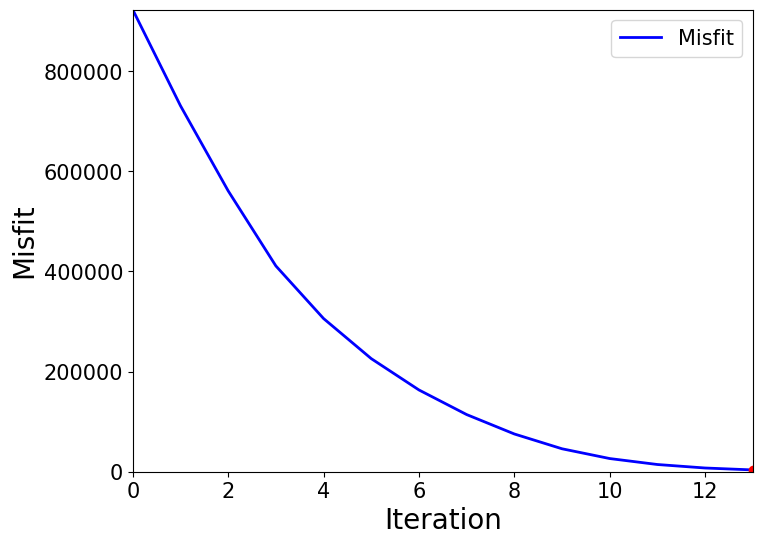

In [52]:
min_index = np.argmin(history)
min_value = history[min_index]

max_index = np.argmax(history[:min_index+1])
max_value = history[max_index]


plt.figure(figsize=(8, 6))
plt.xlim([0, min_index])
plt.ylim([0, max_value])

plt.plot(history, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')



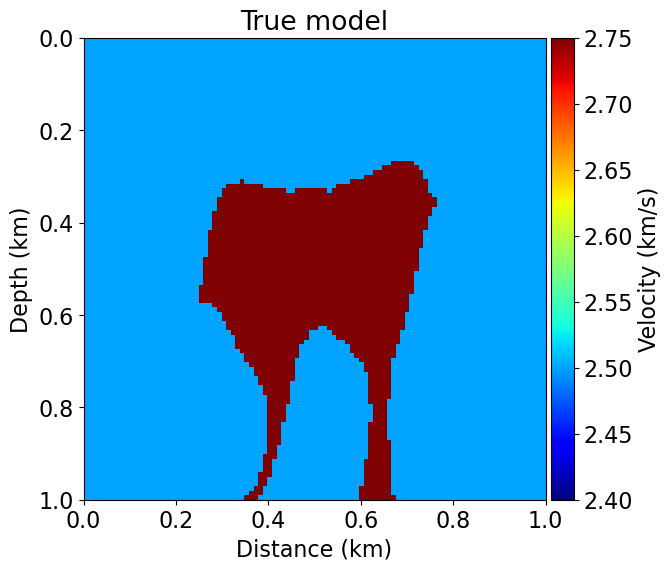

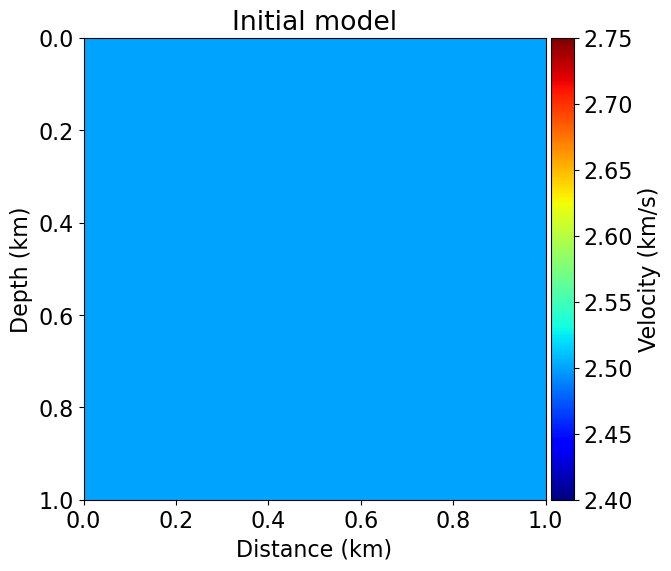

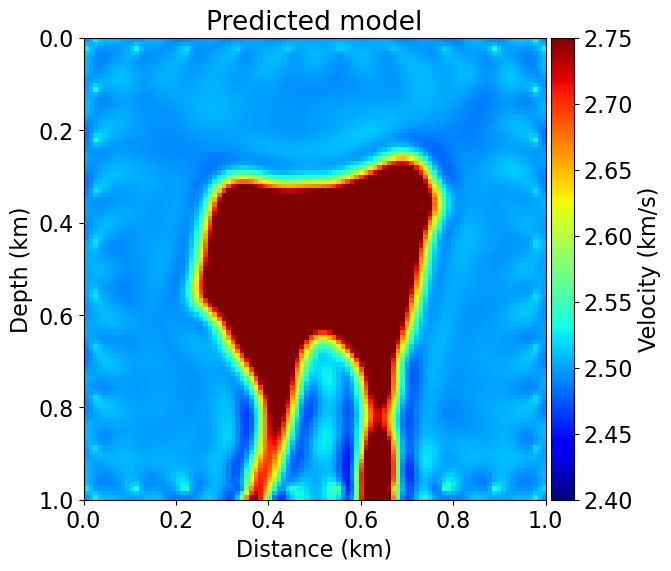

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


plot_velocity_clim(true_model, vmin=2.4, vmax=2.75,name="True model", cmap="jet")
plot_velocity_clim(start_model, vmin=2.4, vmax=2.75,name="Initial model", cmap="jet")

pred_temp=(predicted_model[:,:,min_index-1])
pred_temp=np.transpose(pred_temp[nbl:(shape[0]+2*nbl)-nbl,nbl:(shape[1]+2*nbl)-nbl])
pred_model = Model(vp=pred_temp, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(pred_model, vmin=2.4, vmax=2.75,name="Predicted model", cmap="jet")


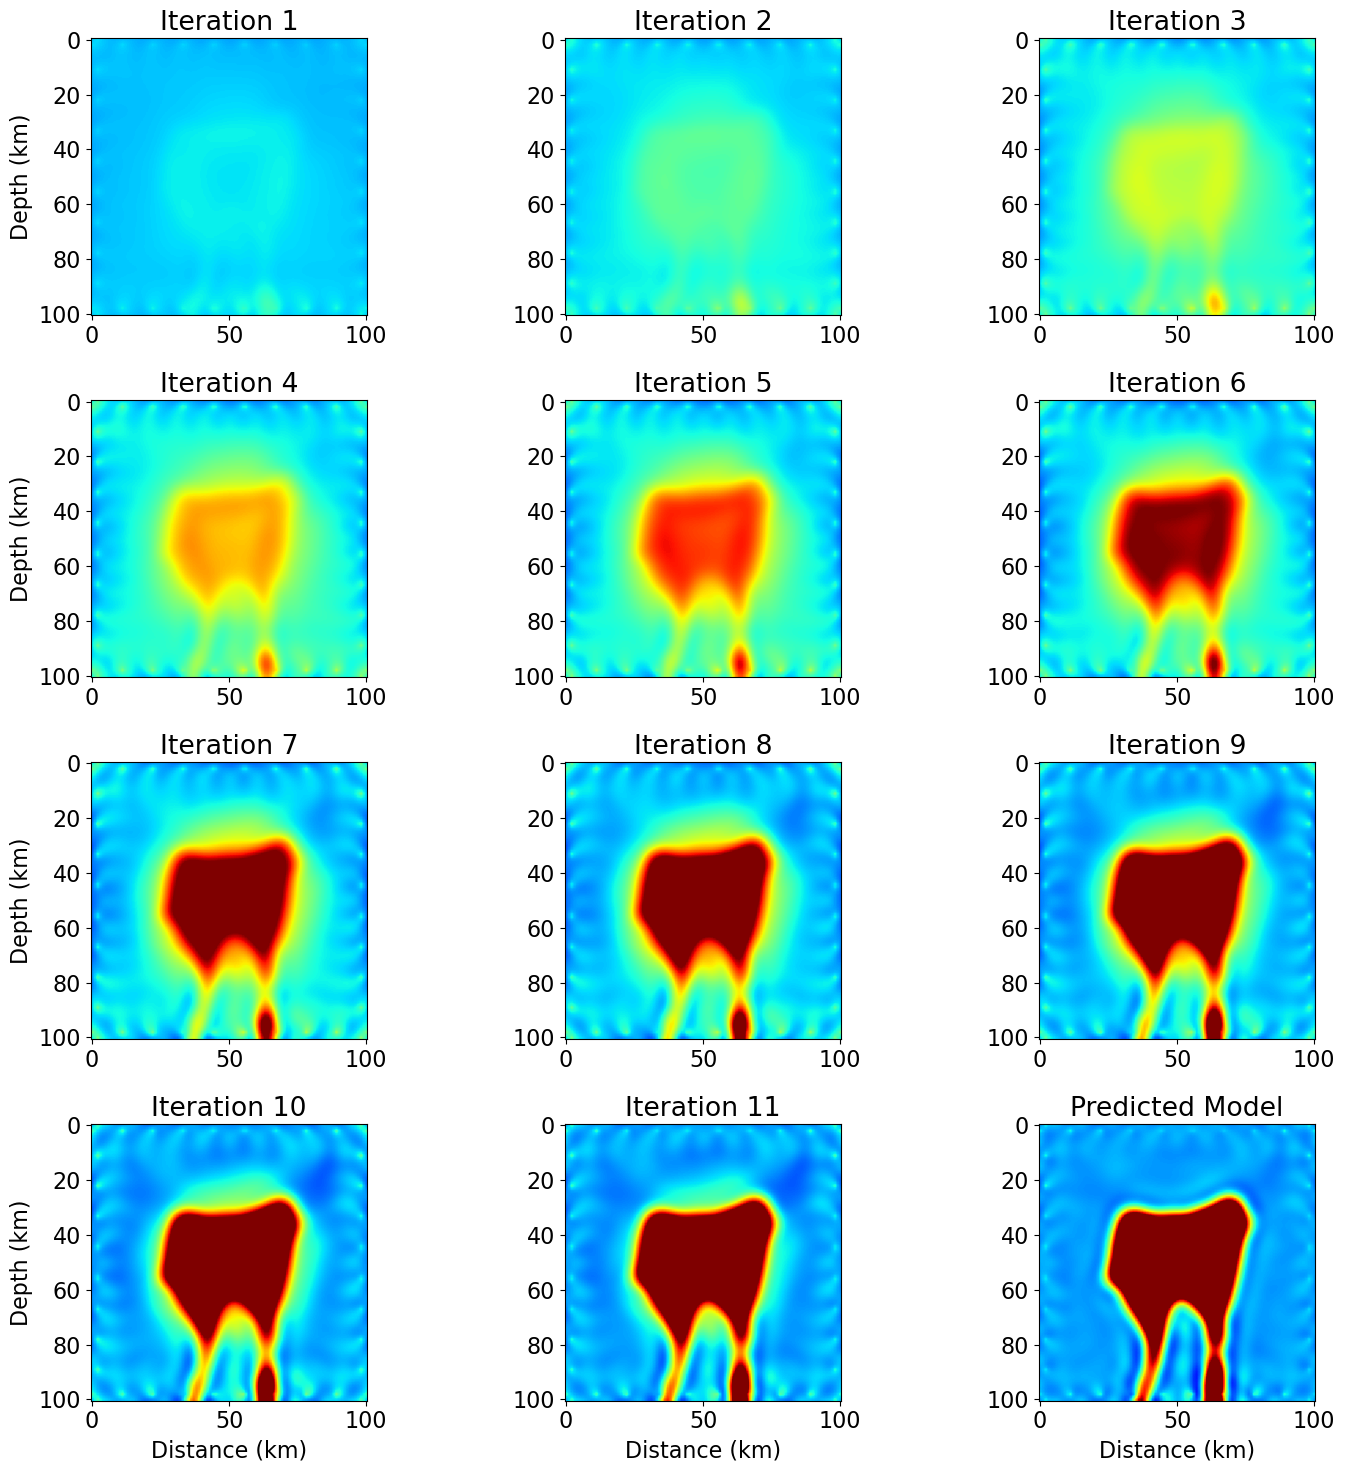

In [106]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
start_mod = start_model.vp.data[nbl:shape[0]+nbl, nbl:shape[1]+nbl]

im_starting = axes[0, 0].imshow(start_mod, cmap="jet", vmin=2.4, vmax=2.75)
axes[0, 0].set_title('Starting Model')
axes[0, 0].set_ylabel('Depth (km)') 

for i in range(4):
    for j in range(3):
        iteration = i * 3 + j
        if iteration <= fwi_iterations - 2: 
            pred_temp = predicted_model[:, :, iteration]
            im = axes[i, j].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl], cmap="jet", vmin=2.4, vmax=2.75)
            axes[i, j].set_title(f'Iteration {iteration+1}')
            if i == 3: 
                axes[i, j].set_xlabel('Distance (km)')
            if j == 0 and i != 0: 
                axes[i, j].set_ylabel('Depth (km)')
        else:
            axes[i, j].axis('off')

if fwi_iterations - 2 >= 12: 
    pred_temp = predicted_model[:, :, min_index - 1]
    im_predicted = axes[3, 2].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl], cmap="jet", vmin=2.4, vmax=2.75)
    axes[3, 2].set_title('Predicted Model')
    axes[3, 2].set_xlabel('Distance (km)')

plt.tight_layout()
plt.show()


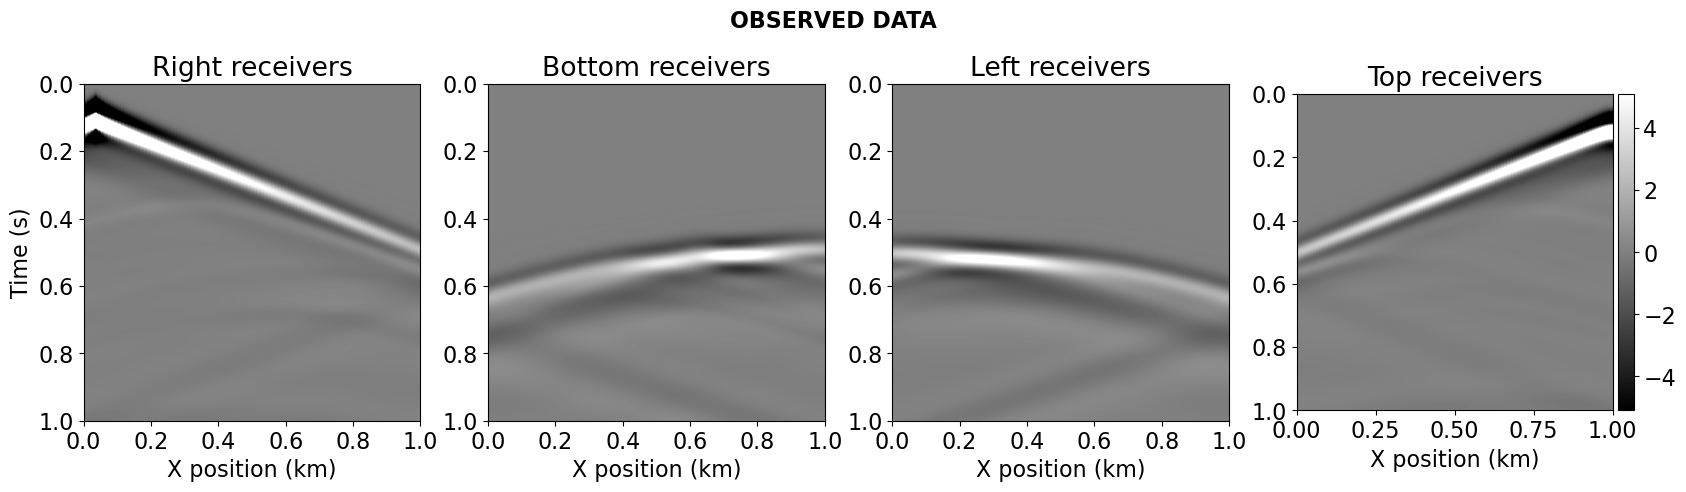

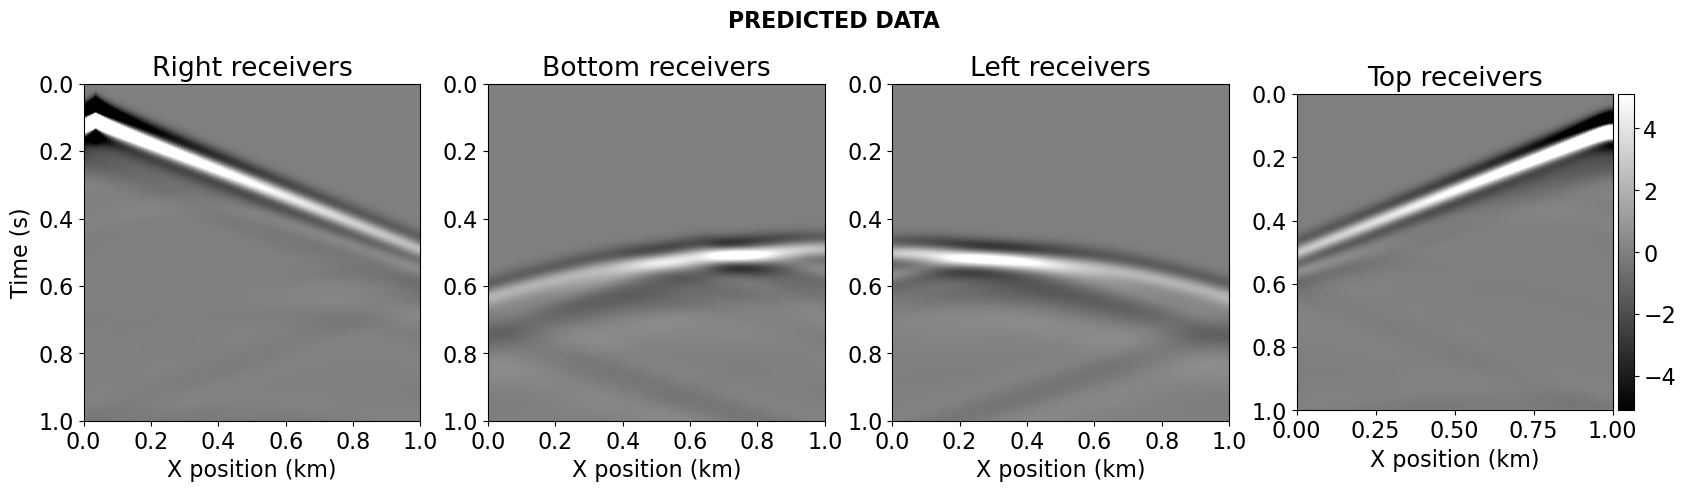

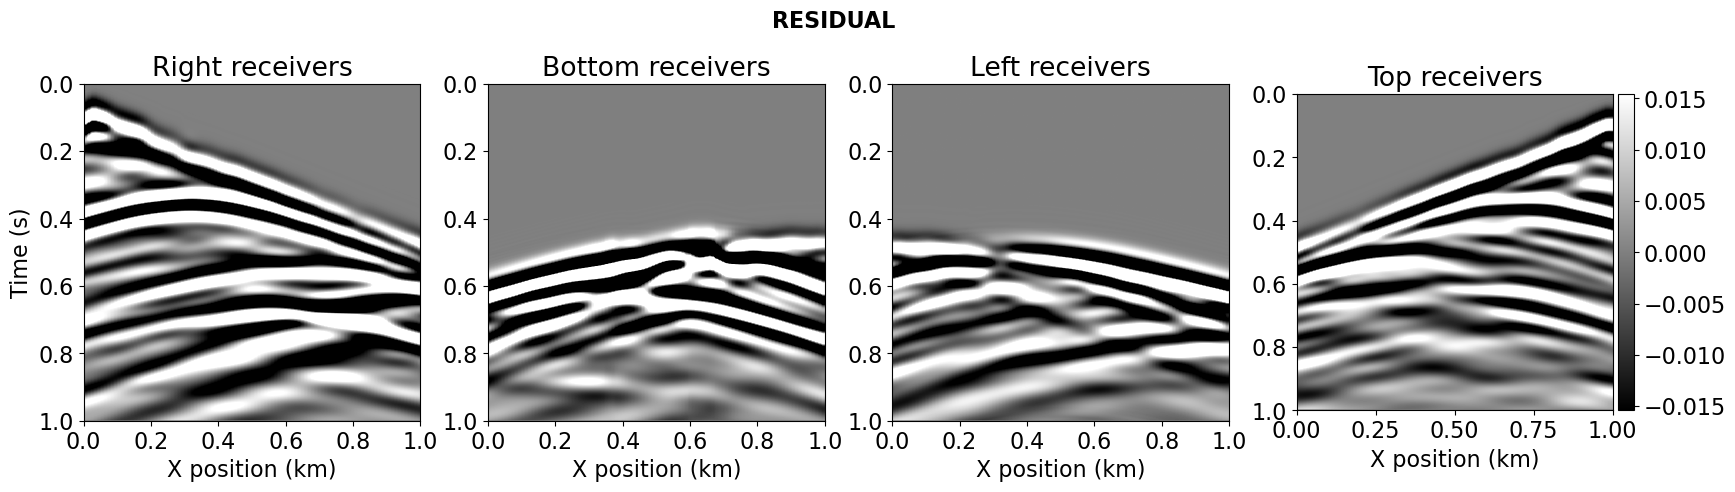

In [60]:
from examples.seismic import plot_shotrecord
from matplotlib import cm
true_d, _, _ = solver.forward(vp=true_model.vp)
pred_d, _, _ = solver.forward(vp=pred_model.vp)

plot_shotrecord_array(true_d.data, true_model, t0, time, case_rcv, colorbar=True,name='OBSERVED DATA')
plot_shotrecord_array(pred_d.data, true_model, t0, time, case_rcv, colorbar=True,name='PREDICTED DATA')
plot_shotrecord_array(pred_d.data - true_d.data, true_model, t0, time, case_rcv, colorbar=True,name='RESIDUAL')


# Reverse Time Migration

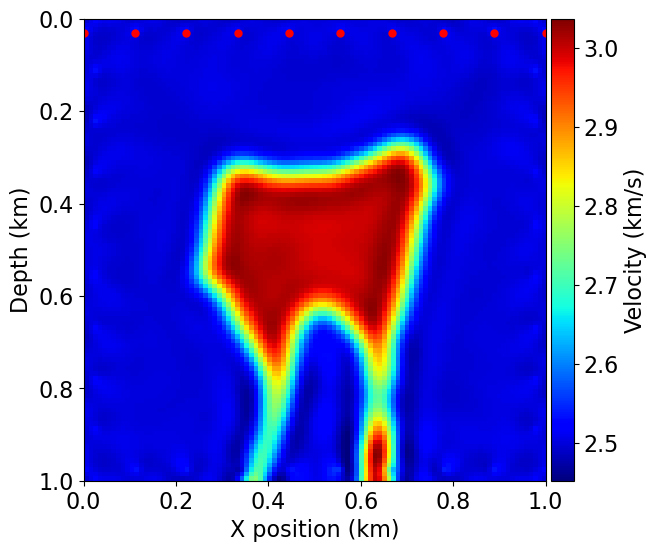

In [65]:
# Define gradient operator for imaging

source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., 1000, num=nshots)
source_locations[:, 1] = 30.

RTM_model=pred_model
model=true_model

plot_velocity(RTM_model, source=source_locations)

Imaging source 1 out of 10
Imaging source 2 out of 10
Imaging source 3 out of 10
Imaging source 4 out of 10
Imaging source 5 out of 10
Imaging source 6 out of 10
Imaging source 7 out of 10
Imaging source 8 out of 10
Imaging source 9 out of 10
Imaging source 10 out of 10


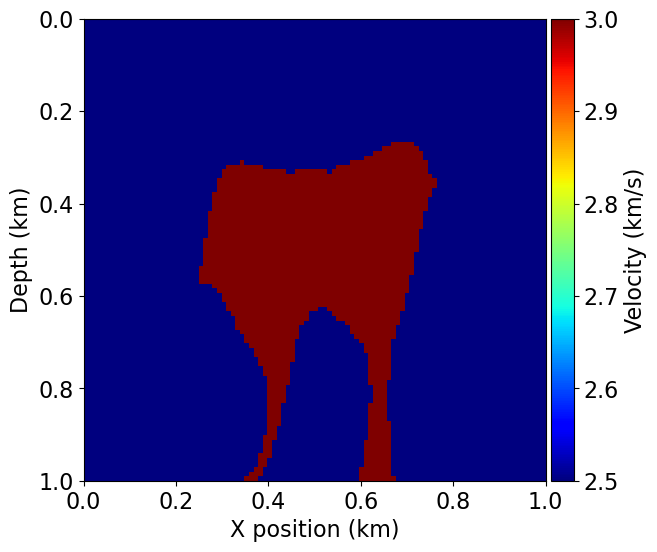

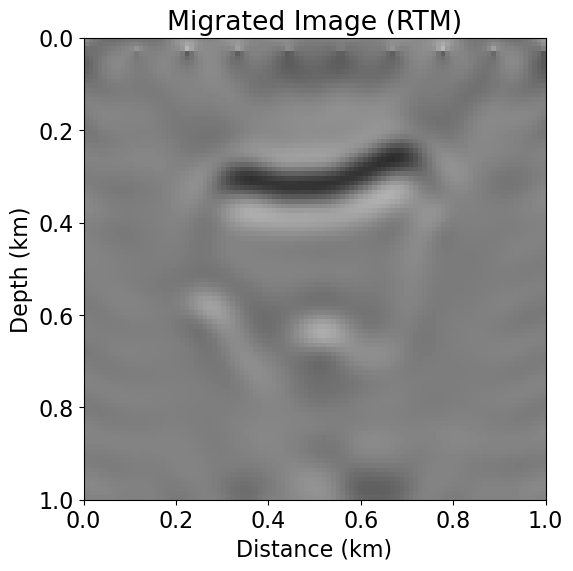

In [101]:
from devito import Function

image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image, geometry)

for i in range(nshots):
    print('Imaging source %d out of %d' % (i+1, nshots))
    geometry.src_positions[0, :] = source_locations[i, :]
    true_d, _, _ = solver.forward(vp=model.vp)
    smooth_d, u0, _ = solver.forward(vp=RTM_model.vp, save=True)
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=RTM_model.vp, dt=RTM_model.critical_dt, 
               residual=residual)

from examples.seismic import plot_image

img=image.data[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
plot_velocity(true_model)
imagen=np.transpose(np.diff(img, axis=1))

plt.imshow(imagen,cmap='gray',vmin=-30000, vmax=30000, extent=[0, 1, 1, 0])
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')
plt.title('Migrated Image (RTM)')
plt.show()


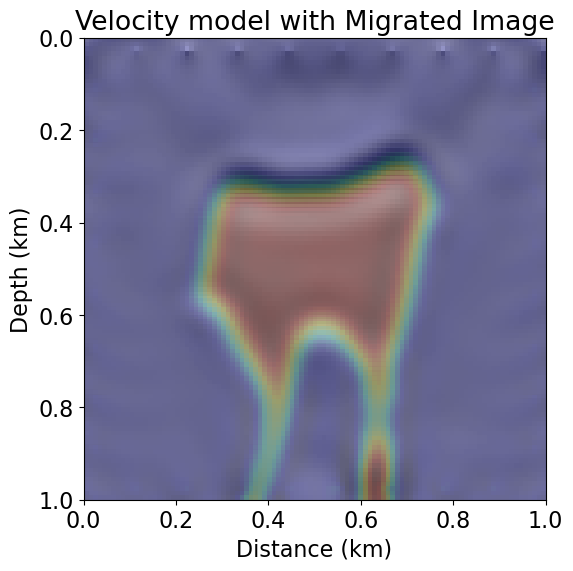

In [105]:
modelo=np.transpose(RTM_model.vp.data[nbl:shape[0]+nbl,nbl:shape[1]+nbl])

plt.imshow(imagen,cmap='gray',vmin=-30000, vmax=30000, extent=[0, 1, 1, 0])
plt.imshow(modelo, cmap='jet',alpha=0.2, extent=[0, 1, 1, 0])
plt.xlabel('Distance (km)')
plt.ylabel('Depth (km)')
plt.title('Velocity model with Migrated Image')
plt.show()
